# Camera calibration - Implementing using DLT

Use the **Direct Linear Transform** to map 3D-2D correspondences. The camera relates 3D world points and image points by the **Camera Matrix**. This matrix is defined as: 
\begin{equation*}
\begin{bmatrix}
c_{11} &c_{12}  &c_{13}  &c_{34} \\ 
c_{21} &c_{22}  &c_{23}  & c_{23}\\ 
c_{31} & c_{32} & c_{33} & c_{34}
\end{bmatrix}  = 
\begin{bmatrix}
f_x & 0 & u_o\\ 
0 &f_y  &v_o \\ 
0 &0  &1 
\end{bmatrix} \cdot
\begin{bmatrix}
r_{11} &r_{12}  &r_{13}  &t_{34} \\ 
r_{21} &r_{22}  &r_{23}  & t_{23}\\ 
r_{31} &r_{32} &r_{33} & t_{34}
\end{bmatrix} 
\end{equation*}

The camera projection is: 
\begin{equation*}
\begin{bmatrix}
\tilde{u}\\ 
\tilde{v}\\ 
1
\end{bmatrix} = 
\begin{bmatrix}
c_{11} &c_{12}  &c_{13}  &c_{34} \\ 
c_{21} &c_{22}  &c_{23}  & c_{23}\\ 
c_{31} & c_{32} & c_{33} & c_{34}
\end{bmatrix}  \cdot 
\begin{bmatrix}
X_w\\ 
Y_w\\ 
Z_w\\ 
1
\end{bmatrix}
\end{equation*}

\begin{equation*}
\tilde{p_i} = C \cdot \tilde{P_i}
\end{equation*}

Our goal in camera calibration is to discover this 12 parameters in the camera matrix. For this, we need a set of control points with 2D-3D correspondences. In other words, given a point in scene, your location in the image in pixels coordinates is known. 

## Tsai's method
This method consist of estimate the camera matrix using 3D control points of an object with know geometry and their 2D projections. Using an object with know geometry means that the 3D points in world coordinate frame are know. 

### Step 01 - Form the linear system: 
### Step 02 - Compute SVD


In [3]:
#Import the librarys
import numpy as np
import matplotlib.pyplot as plt
from machinevisiontoolbox import CentralCamera



'w_points = np.array([[1., 0.,1],[1,1,1]])\ni_points = cam.project_point(w_points)\nprint(i_points)'

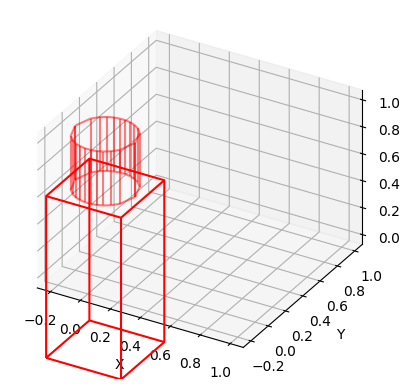

In [31]:
# Create simulate data using Machine Vision Toolbox
cam = CentralCamera(f=0.015, rho=10e-6, imagesize=[1280, 1024], pp=[640, 512], name="mycamera")

cam.plot()

'''w_points = np.array([[1., 0.,1],[1,1,1]])
i_points = cam.project_point(w_points)
print(i_points)'''



In [ ]:
# Define control points

In [ ]:
# Define linear system

In [ ]:
# Compute the svd